In [1]:
import torch
import numpy as np
import random
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data.dataset import random_split

import torch.nn as nn
import time
from matplotlib import pyplot as plt
from IPython.display import clear_output

import copy

import sys
sys.path.append("/Users/charlottebeylier/Documents/PhD/Spatial and Conceptual Learning/github_code/Mono_Multi_TASK/Experimental_setup")
from Experiment_v5 import Experiment
sys.path.append("/Users/charlottebeylier/Documents/PhD/Spatial and Conceptual Learning/github_code/Mono_Multi_TASK/Training")
from Training_Networks import Training
sys.path.append("/Users/charlottebeylier/Documents/PhD/Spatial and Conceptual Learning/github_code/Mono_Multi_TASK/Analysis")
from Check import Checkup
from Hooks import Activation_Hook
sys.path.append("/Users/charlottebeylier/Documents/PhD/Spatial and Conceptual Learning/github_code/Mono_Multi_TASK/Models")
from Networks_v2 import Net_Individual,Net_Multi

from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA, IncrementalPCA

sys.path.append("/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Experiments/Analysis")
from Manifold_Analysis import Manifold_analysis
from matplotlib import animation
from IPython.display import HTML
from tabulate import tabulate


# importing required libraries
from mpl_toolkits.mplot3d import Axes3D

from sklearn.datasets import load_iris
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.manifold import MDS
from sklearn.manifold import Isomap
from sklearn.metrics import pairwise_distances

from matplotlib.ticker import NullFormatter
from collections import OrderedDict
from functools import partial
from sklearn import manifold, datasets

# Reproducibility 

In [2]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

def set_seed(seed=None, seed_torch=True):
    if seed is None:
        seed = np.random.choice(2 ** 32)
    random.seed(seed)
    np.random.seed(seed)
    if seed_torch:
        torch.manual_seed(seed)

    print(f'Random seed {seed} has been set.')

SEED = 2021
set_seed(seed=SEED)


G_SEED = torch.Generator()
G_SEED.manual_seed(SEED)

Device:  cpu
Random seed 2021 has been set.


# Checkup

In [25]:
class Checkup():
    def __init__(self):
        
        pass
    
    
    def Display_Score(self,model,test_loader,epsilon,example,spatial):
        length = 0
        score = 0
        for x_test,y_test in test_loader:
             with torch.no_grad():
                pumpkin_seed = np.int(x_test[0][5])
                if spatial:
                    x_test = x_test[:,0:2]
                else:
                    x_test = x_test[:,2:5]
                yhat = torch.nn.Sigmoid()(model(x_test).squeeze(1))
                length += len(y_test)
                    
                for i in range(len(yhat)):
 
                    if np.abs(yhat[i]- y_test[i] )<epsilon:
                         score+=1


        if example:
            print("Data",x_test)
            print("Target",y_test)
            print("Prediction",yhat)
        print("Score final : ", (score/length)*100)
        

# Conceptual task

## Generate the Dataset

In [4]:
WIDTH = 100
EPOCH = 100
BATCH_SIZE = 32
Nodes_Second = 10
Nodes_Third = 10


In [5]:
set_seed(seed=SEED)
experiment = Experiment(width = WIDTH,batch_size=BATCH_SIZE,size_output_multi=2)
dataset_train,dataset_space_train,dataset_weather_train,dataset_val,dataset_space_val,dataset_weather_val,dataset_test,dataset_space_test,dataset_weather_test= experiment.Generate_data()
train_loader = torch.utils.data.DataLoader(dataset_weather_train,batch_size=10,shuffle = False )
val_loader = torch.utils.data.DataLoader(dataset_weather_val,batch_size=1,shuffle = False )
test_loader_weather = torch.utils.data.DataLoader(dataset_weather_test,batch_size=1,shuffle = False ) #bATCH SIZE =1 HERE FOR THE DATASET ONLY, ELSE TAKE WHATEVER BATCH SIZE IN INDIVIDUAL MODE

Random seed 2021 has been set.
Test size dataset space torch.Size([999, 6])
Test size dataset weather torch.Size([999, 6])
Train size dataset space torch.Size([7000, 6])
Train size dataset weather torch.Size([7000, 6])


## Initalize the Network

In [7]:
model_weather = Net_Individual(input_dimension=3,nodes_second = Nodes_Second,nodes_third = Nodes_Third,nodes_output = 1)    
optimizer = torch.optim.Adam(model_weather.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
criterion = nn.BCEWithLogitsLoss()


## Training

Epoch 99, val_loss 0.023915825634374804


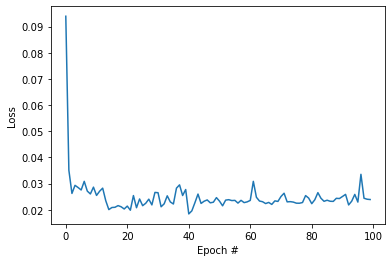

In [8]:


losses = []
val_losses = []

for epoch in range(EPOCH):

    loss = 0
    val_loss = 0 

    for x_batch, y_batch in train_loader:

        x_batch = x_batch[:,2:5]
            
        optimizer.zero_grad()
        output = model_weather(x_batch).squeeze(1)

        output_loss = criterion(output,y_batch)
        output_loss.backward()
        optimizer.step()
            
        loss += output_loss.detach().numpy()
    losses.append(loss/len(train_loader))
            
    with torch.no_grad():
        for x_val, y_val in val_loader:
            model_weather.eval() # not useful for now
            x_val = x_val[:,2:5]
            yhat = model_weather(x_val).squeeze(1)
            val_loss += criterion(yhat,y_val)
        val_losses.append(val_loss.item()/len(val_loader))


    if np.mod(epoch,1)==0: 
        clear_output()
        print("Epoch {}, val_loss {}".format(epoch, val_loss.item()/len(val_loader))) 
        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.plot(np.arange(len(val_losses)), val_losses)
        plt.ylabel('Loss')
        plt.xlabel('Epoch #')
        plt.show()
            
            



## Accuracy Score

In [9]:
checkUP = Checkup() 
EPSILON = 0.3
checkUP.Display_Score(model_weather,test_loader_weather, EPSILON,True,False)

Data tensor([[0.9200, 0.4000, 0.6800]])
Target tensor([0.])
Prediction tensor([8.6673e-06])
Score final :  98.3983983983984


# Spatial Task

## Generate the Dataset

In [10]:
set_seed(seed=SEED)
experiment = Experiment(width = WIDTH,batch_size=BATCH_SIZE,size_output_multi=2)
dataset_train,dataset_space_train,dataset_weather_train,dataset_val,dataset_space_val,dataset_weather_val,dataset_test,dataset_space_test,dataset_weather_test= experiment.Generate_data()
train_loader = torch.utils.data.DataLoader(dataset_space_train,batch_size=10,shuffle = False )
val_loader = torch.utils.data.DataLoader(dataset_space_val,batch_size=1,shuffle = False )
test_loader_space = torch.utils.data.DataLoader(dataset_space_test,batch_size=1,shuffle = False ) #bATCH SIZE =1 HERE FOR THE DATASET ONLY, ELSE TAKE WHATEVER BATCH SIZE IN INDIVIDUAL MODE


Random seed 2021 has been set.
Test size dataset space torch.Size([999, 6])
Test size dataset weather torch.Size([999, 6])
Train size dataset space torch.Size([7000, 6])
Train size dataset weather torch.Size([7000, 6])


## Initalize the Network

In [11]:

model_space = Net_Individual(input_dimension=2,nodes_second = Nodes_Second,nodes_third = Nodes_Third,nodes_output = 1)    


model_space.fc2[0].weight = model_weather.fc2[0].weight
model_space.fc3[0].weight = model_weather.fc3[0].weight

optimizer = torch.optim.Adam(model_space.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
criterion = nn.BCEWithLogitsLoss()

for param in model_space.fc2.parameters():
    param.requires_grad = False


for param in model_space.fc3.parameters():
    param.requires_grad = False



## Training

Epoch 99, val_loss 0.01751441249494376


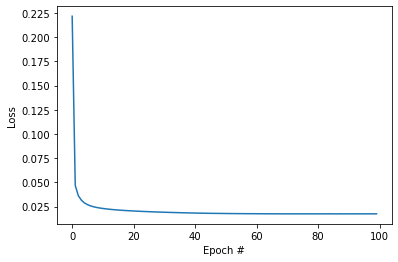

In [12]:


losses = []
val_losses = []

for epoch in range(EPOCH):

    loss = 0
    val_loss = 0 

    for x_batch, y_batch in train_loader:

        x_batch = x_batch[:,0:2]
            
        optimizer.zero_grad()
        output = model_space(x_batch).squeeze(1)

        output_loss = criterion(output,y_batch)
        output_loss.backward()
        optimizer.step()
            
        loss += output_loss.detach().numpy()
    losses.append(loss/len(train_loader))
            
    with torch.no_grad():
        for x_val, y_val in val_loader:
            model_space.eval() # not useful for now
            x_val = x_val[:,0:2]
            yhat = model_space(x_val).squeeze(1)
            val_loss += criterion(yhat,y_val)
        val_losses.append(val_loss.item()/len(val_loader))


    if np.mod(epoch,1)==0: 
        
        clear_output()
        print("Epoch {}, val_loss {}".format(epoch, val_loss.item()/len(val_loader))) 
        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.plot(np.arange(len(val_losses)), val_losses)
        plt.ylabel('Loss')
        plt.xlabel('Epoch #')
        plt.show()
            
            



In [13]:
print(model_space)

Net_Individual(
  (fc1): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): ReLU()
  )
  (fc3): Sequential(
    (0): Linear(in_features=10, out_features=1, bias=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [14]:
y = 0
episode = 0
for x_test,y_test in test_loader_space:
    with torch.no_grad():
        pumpkin_seed = np.int(x_test[0][5])
        x_test = x_test[:,0:2]
        yhat = torch.nn.Sigmoid()(model_space(x_test).squeeze(1))
        print("pumpkin_seed",pumpkin_seed)
        print(y_test)
        print(yhat )
          

pumpkin_seed 1
tensor([0.])
tensor([1.0071e-08])
pumpkin_seed 1
tensor([0.])
tensor([1.6251e-05])
pumpkin_seed 1
tensor([0.])
tensor([2.2401e-06])
pumpkin_seed 1
tensor([0.])
tensor([2.5034e-30])
pumpkin_seed 1
tensor([0.])
tensor([9.2341e-13])
pumpkin_seed 1
tensor([0.])
tensor([1.4790e-16])
pumpkin_seed 1
tensor([0.])
tensor([4.8881e-07])
pumpkin_seed 1
tensor([1.])
tensor([0.9999])
pumpkin_seed 1
tensor([1.])
tensor([0.9872])
pumpkin_seed 1
tensor([0.])
tensor([2.1805e-09])
pumpkin_seed 1
tensor([0.])
tensor([2.8440e-05])
pumpkin_seed 1
tensor([0.])
tensor([5.1319e-20])
pumpkin_seed 1
tensor([0.])
tensor([0.0003])
pumpkin_seed 1
tensor([1.])
tensor([1.0000])
pumpkin_seed 1
tensor([0.])
tensor([4.9986e-05])
pumpkin_seed 1
tensor([0.])
tensor([0.0028])
pumpkin_seed 1
tensor([0.])
tensor([0.])
pumpkin_seed 1
tensor([1.])
tensor([0.9999])
pumpkin_seed 1
tensor([1.])
tensor([1.0000])
pumpkin_seed 1
tensor([0.])
tensor([0.0003])
pumpkin_seed 1
tensor([0.])
tensor([5.8083e-12])
pumpkin_see

tensor([2.4534e-12])
pumpkin_seed 1
tensor([1.])
tensor([0.4161])
pumpkin_seed 1
tensor([1.])
tensor([1.])
pumpkin_seed 1
tensor([0.])
tensor([4.0979e-09])
pumpkin_seed 1
tensor([0.])
tensor([2.6383e-21])
pumpkin_seed 1
tensor([0.])
tensor([1.4209e-16])
pumpkin_seed 1
tensor([0.])
tensor([1.6024e-06])
pumpkin_seed 1
tensor([0.])
tensor([3.6000e-33])
pumpkin_seed 1
tensor([0.])
tensor([2.3136e-09])
pumpkin_seed 1
tensor([0.])
tensor([6.6176e-24])
pumpkin_seed 1
tensor([0.])
tensor([7.8624e-12])
pumpkin_seed 1
tensor([0.])
tensor([6.1418e-08])
pumpkin_seed 1
tensor([0.])
tensor([4.5329e-19])
pumpkin_seed 1
tensor([0.])
tensor([2.4050e-30])
pumpkin_seed 1
tensor([0.])
tensor([7.0773e-05])
pumpkin_seed 1
tensor([0.])
tensor([2.1053e-07])
pumpkin_seed 1
tensor([0.])
tensor([7.9054e-21])
pumpkin_seed 1
tensor([0.])
tensor([1.3811e-11])
pumpkin_seed 1
tensor([0.])
tensor([1.1004e-24])
pumpkin_seed 1
tensor([0.])
tensor([5.4536e-09])
pumpkin_seed 1
tensor([0.])
tensor([4.2679e-11])
pumpkin_see

tensor([4.6734e-06])
pumpkin_seed 1
tensor([0.])
tensor([5.5957e-05])
pumpkin_seed 1
tensor([0.])
tensor([4.1207e-09])
pumpkin_seed 1
tensor([0.])
tensor([5.3070e-08])
pumpkin_seed 1
tensor([0.])
tensor([7.8495e-08])
pumpkin_seed 1
tensor([0.])
tensor([1.5412e-07])
pumpkin_seed 1
tensor([1.])
tensor([1.0000])
pumpkin_seed 1
tensor([0.])
tensor([3.9487e-06])
pumpkin_seed 1
tensor([0.])
tensor([7.1916e-09])
pumpkin_seed 1
tensor([1.])
tensor([1.0000])
pumpkin_seed 1
tensor([0.])
tensor([1.2631e-29])
pumpkin_seed 1
tensor([1.])
tensor([1.0000])
pumpkin_seed 1
tensor([1.])
tensor([0.9995])
pumpkin_seed 1
tensor([1.])
tensor([1.0000])
pumpkin_seed 1
tensor([0.])
tensor([6.4143e-13])
pumpkin_seed 1
tensor([0.])
tensor([0.0005])
pumpkin_seed 1
tensor([0.])
tensor([1.2441e-09])
pumpkin_seed 1
tensor([0.])
tensor([3.8703e-06])
pumpkin_seed 1
tensor([0.])
tensor([3.8830e-13])
pumpkin_seed 1
tensor([0.])
tensor([4.4771e-38])
pumpkin_seed 1
tensor([1.])
tensor([1.0000])
pumpkin_seed 1
tensor([0.])

tensor([3.9936e-05])
pumpkin_seed 1
tensor([0.])
tensor([6.6830e-12])
pumpkin_seed 1
tensor([0.])
tensor([0.0004])
pumpkin_seed 1
tensor([1.])
tensor([1.0000])
pumpkin_seed 1
tensor([1.])
tensor([1.])
pumpkin_seed 1
tensor([1.])
tensor([1.0000])
pumpkin_seed 1
tensor([0.])
tensor([6.6668e-17])
pumpkin_seed 1
tensor([1.])
tensor([0.9206])
pumpkin_seed 1
tensor([1.])
tensor([0.9893])
pumpkin_seed 1
tensor([0.])
tensor([0.0003])
pumpkin_seed 1
tensor([0.])
tensor([0.0170])
pumpkin_seed 1
tensor([0.])
tensor([3.4981e-05])
pumpkin_seed 1
tensor([0.])
tensor([6.9211e-07])
pumpkin_seed 1
tensor([1.])
tensor([1.0000])
pumpkin_seed 1
tensor([0.])
tensor([0.0009])
pumpkin_seed 1
tensor([0.])
tensor([6.0470e-19])
pumpkin_seed 1
tensor([0.])
tensor([0.0001])
pumpkin_seed 1
tensor([0.])
tensor([9.3265e-19])
pumpkin_seed 1
tensor([1.])
tensor([0.9995])
pumpkin_seed 1
tensor([1.])
tensor([0.9997])
pumpkin_seed 1
tensor([0.])
tensor([3.2752e-14])
pumpkin_seed 1
tensor([0.])
tensor([3.2956e-08])
pumpki

tensor([0.])
tensor([2.5731e-13])
pumpkin_seed 1
tensor([0.])
tensor([6.5338e-09])
pumpkin_seed 1
tensor([0.])
tensor([3.5022e-32])
pumpkin_seed 1
tensor([0.])
tensor([0.])
pumpkin_seed 1
tensor([0.])
tensor([1.0891e-07])
pumpkin_seed 1
tensor([0.])
tensor([1.9492e-07])
pumpkin_seed 1
tensor([0.])
tensor([6.9057e-27])
pumpkin_seed 1
tensor([0.])
tensor([1.0737e-06])
pumpkin_seed 1
tensor([0.])
tensor([1.4003e-06])
pumpkin_seed 1
tensor([0.])
tensor([4.9016e-07])
pumpkin_seed 1
tensor([0.])
tensor([1.7017e-16])
pumpkin_seed 1
tensor([1.])
tensor([0.9913])
pumpkin_seed 1
tensor([0.])
tensor([5.0211e-08])
pumpkin_seed 1
tensor([1.])
tensor([1.0000])
pumpkin_seed 1
tensor([1.])
tensor([1.0000])
pumpkin_seed 1
tensor([0.])
tensor([5.6544e-05])
pumpkin_seed 1
tensor([1.])
tensor([0.9991])
pumpkin_seed 1
tensor([0.])
tensor([0.0002])
pumpkin_seed 1
tensor([0.])
tensor([4.0714e-13])
pumpkin_seed 1
tensor([0.])
tensor([2.4347e-13])
pumpkin_seed 1
tensor([0.])
tensor([1.2693e-09])
pumpkin_seed 1

## Accuracy Score

In [26]:
checkUP = Checkup() 
EPSILON = 0.3
checkUP.Display_Score(model_space,test_loader_space, EPSILON,True,True)

Data tensor([[0.1900, 0.1600]])
Target tensor([1.])
Prediction tensor([1.])
Score final :  98.3983983983984


# Representational Space Analysis

## Sample activation outputs

In [34]:
Liste_models = [model_weather,model_space]


#Liste_models = [Model_space]
activation_hook = Activation_Hook()


Names_hook = ["fc1","fc2","fc3"]
episode  = 0

Liste_activation = [[[] for i in range(len(Names_hook))] for j in range(len( Liste_models ))]
Liste_test_loader = [test_loader_weather,test_loader_space]



for num_model in range(len(Liste_models)):
    print("num_model",num_model)
    model = Liste_models[num_model]
    activation_hook.registration(model)
    episode = 0
    for x_test,y_test in Liste_test_loader[num_model]:
        with torch.no_grad():
            pumpkin_seed = np.int(x_test[0][5])

            if num_model ==0:
                x_test = x_test[:,2:5]
            if num_model ==1:
                x_test = x_test[:,0:2]
            
            yhat = torch.nn.Sigmoid()(model(x_test).squeeze(1))
            print("x_test",x_test)
            print("yhat",yhat)
            print("y_test",y_test)
            for h in range(len(Names_hook)):

                b = torch.flatten(activation_hook.activation[Names_hook[h]])
    
                Liste_activation[num_model][h].append(b)  # If concatenate list directly with Liste_activation[agent_number][h] += torch.flatten(agent.activation[Names_hook[h]]) takes much more time
        
        episode += 1
    activation_hook.detach()



num_model 0
x_test tensor([[0.0200, 0.4100, 0.0800]])
yhat tensor([2.1279e-11])
y_test tensor([0.])
x_test tensor([[0.2400, 0.6700, 0.9700]])
yhat tensor([3.7286e-18])
y_test tensor([0.])
x_test tensor([[0.1100, 0.5900, 0.2500]])
yhat tensor([2.1849e-14])
y_test tensor([0.])
x_test tensor([[0.8700, 0.9600, 0.6200]])
yhat tensor([7.8492e-06])
y_test tensor([0.])
x_test tensor([[0.6000, 0.8100, 0.3000]])
yhat tensor([5.9097e-10])
y_test tensor([0.])
x_test tensor([[0.9900, 0.9000, 0.3800]])
yhat tensor([0.0004])
y_test tensor([0.])
x_test tensor([[0.8100, 0.9500, 0.3500]])
yhat tensor([5.4696e-08])
y_test tensor([0.])
x_test tensor([[0.5200, 0.7100, 0.8900]])
yhat tensor([7.5741e-07])
y_test tensor([0.])
x_test tensor([[0.3800, 0.9200, 0.2000]])
yhat tensor([8.7873e-23])
y_test tensor([0.])
x_test tensor([[0.6400, 0.5500, 0.4500]])
yhat tensor([0.0104])
y_test tensor([0.])
x_test tensor([[0.5500, 0.7900, 0.7200]])
yhat tensor([0.0002])
y_test tensor([0.])
x_test tensor([[0.4300, 0.4000, 

x_test tensor([[0.1700, 0.2500, 0.4000]])
yhat tensor([0.0022])
y_test tensor([0.])
x_test tensor([[0.8300, 0.3700, 0.0000]])
yhat tensor([9.7516e-10])
y_test tensor([0.])
x_test tensor([[0.0200, 0.3800, 0.7900]])
yhat tensor([1.1575e-17])
y_test tensor([0.])
x_test tensor([[0.3800, 0.2900, 0.2600]])
yhat tensor([0.9851])
y_test tensor([1.])
x_test tensor([[0.3200, 0.8900, 0.3800]])
yhat tensor([1.5642e-22])
y_test tensor([0.])
x_test tensor([[0.3200, 0.1200, 0.0800]])
yhat tensor([6.5794e-06])
y_test tensor([0.])
x_test tensor([[0.9300, 0.2800, 0.8500]])
yhat tensor([1.4237e-16])
y_test tensor([0.])
x_test tensor([[0.3100, 0.9000, 0.0800]])
yhat tensor([3.4069e-25])
y_test tensor([0.])
x_test tensor([[0.8300, 0.5900, 0.9800]])
yhat tensor([9.9688e-17])
y_test tensor([0.])
x_test tensor([[0.6600, 0.9100, 0.5200]])
yhat tensor([9.9489e-11])
y_test tensor([0.])
x_test tensor([[0.6900, 0.5400, 0.9900]])
yhat tensor([1.0570e-24])
y_test tensor([0.])
x_test tensor([[0.8700, 0.8900, 0.4400]]

yhat tensor([1.3484e-09])
y_test tensor([0.])
x_test tensor([[0.1400, 0.0600, 0.3000]])
yhat tensor([5.3634e-06])
y_test tensor([0.])
x_test tensor([[0.4300, 0.7200, 0.4600]])
yhat tensor([2.2261e-07])
y_test tensor([0.])
x_test tensor([[0.0400, 0.6000, 0.8600]])
yhat tensor([5.1542e-24])
y_test tensor([0.])
x_test tensor([[0.0200, 0.0600, 0.8000]])
yhat tensor([6.7932e-39])
y_test tensor([0.])
x_test tensor([[0.0000, 0.4500, 0.0500]])
yhat tensor([2.5613e-15])
y_test tensor([0.])
x_test tensor([[0.0800, 0.4900, 0.0600]])
yhat tensor([8.6328e-16])
y_test tensor([0.])
x_test tensor([[0.8900, 0.9700, 0.3300]])
yhat tensor([2.6523e-06])
y_test tensor([0.])
x_test tensor([[0.5100, 0.0700, 0.3000]])
yhat tensor([4.3973e-05])
y_test tensor([0.])
x_test tensor([[0.1400, 0.0100, 0.6400]])
yhat tensor([4.3547e-39])
y_test tensor([0.])
x_test tensor([[0.9600, 0.0900, 0.6400]])
yhat tensor([7.3784e-10])
y_test tensor([0.])
x_test tensor([[0.8200, 0.9600, 0.6700]])
yhat tensor([3.5414e-07])
y_test

x_test tensor([[0.2900, 0.3700, 0.0800]])
yhat tensor([2.5887e-05])
y_test tensor([0.])
x_test tensor([[0.5900, 0.3200, 0.8800]])
yhat tensor([4.2140e-30])
y_test tensor([0.])
x_test tensor([[0.2400, 0.8000, 0.6000]])
yhat tensor([7.8566e-18])
y_test tensor([0.])
x_test tensor([[0.3700, 0.7200, 0.1400]])
yhat tensor([2.0458e-14])
y_test tensor([0.])
x_test tensor([[0.3900, 0.2000, 0.7200]])
yhat tensor([3.4472e-30])
y_test tensor([0.])
x_test tensor([[0.9800, 0.9600, 0.7900]])
yhat tensor([0.0013])
y_test tensor([0.])
x_test tensor([[0.1000, 0.5700, 0.2100]])
yhat tensor([2.2138e-14])
y_test tensor([0.])
x_test tensor([[0.5600, 0.0800, 0.6200]])
yhat tensor([3.7771e-21])
y_test tensor([0.])
x_test tensor([[0.4300, 0.9400, 0.1800]])
yhat tensor([1.1696e-21])
y_test tensor([0.])
x_test tensor([[0.1700, 0.5600, 0.7900]])
yhat tensor([2.3301e-15])
y_test tensor([0.])
x_test tensor([[0.2600, 0.0400, 0.7600]])
yhat tensor([0.])
y_test tensor([0.])
x_test tensor([[0.9000, 0.2500, 0.9500]])
yh

x_test tensor([[0.6700, 0.6100, 0.3900]])
yhat tensor([0.0006])
y_test tensor([0.])
x_test tensor([[0.4200, 0.7600, 0.6900]])
yhat tensor([9.8721e-09])
y_test tensor([0.])
x_test tensor([[0.2900, 0.7600, 0.0900]])
yhat tensor([1.2245e-19])
y_test tensor([0.])
x_test tensor([[0.8200, 0.2800, 0.4900]])
yhat tensor([6.0641e-07])
y_test tensor([0.])
x_test tensor([[0.9800, 0.5600, 0.5300]])
yhat tensor([1.2667e-10])
y_test tensor([0.])
x_test tensor([[0.5300, 0.5800, 0.1000]])
yhat tensor([4.4401e-05])
y_test tensor([0.])
x_test tensor([[0.5000, 0.9500, 0.6000]])
yhat tensor([7.9373e-14])
y_test tensor([0.])
x_test tensor([[0.9200, 0.2500, 0.7700]])
yhat tensor([6.2972e-12])
y_test tensor([0.])
x_test tensor([[0.2400, 0.9800, 0.7600]])
yhat tensor([3.3592e-25])
y_test tensor([0.])
x_test tensor([[0.2000, 0.9400, 0.6900]])
yhat tensor([3.2727e-25])
y_test tensor([0.])
x_test tensor([[0.5600, 0.0400, 0.2900]])
yhat tensor([2.9856e-05])
y_test tensor([0.])
x_test tensor([[0.2100, 0.4300, 0.61

x_test tensor([[0.4000, 0.2600, 0.4100]])
yhat tensor([0.0187])
y_test tensor([1.])
x_test tensor([[0.3500, 0.5800, 0.8000]])
yhat tensor([4.0550e-09])
y_test tensor([0.])
x_test tensor([[0.7400, 0.3100, 0.0900]])
yhat tensor([1.3721e-09])
y_test tensor([0.])
x_test tensor([[0.1200, 0.6900, 0.4800]])
yhat tensor([2.4675e-18])
y_test tensor([0.])
x_test tensor([[0.5200, 0.0100, 0.8500]])
yhat tensor([0.])
y_test tensor([0.])
x_test tensor([[0.0000, 0.0600, 0.7600]])
yhat tensor([3.3241e-34])
y_test tensor([0.])
x_test tensor([[0.2000, 0.7500, 0.8500]])
yhat tensor([1.6778e-20])
y_test tensor([0.])
x_test tensor([[0.3500, 0.5400, 0.1900]])
yhat tensor([7.8964e-09])
y_test tensor([0.])
x_test tensor([[0.3000, 0.9700, 0.5700]])
yhat tensor([5.4728e-22])
y_test tensor([0.])
x_test tensor([[0.0600, 0.3600, 0.0200]])
yhat tensor([5.3842e-10])
y_test tensor([0.])
x_test tensor([[0.3400, 0.9000, 0.4400]])
yhat tensor([2.3196e-20])
y_test tensor([0.])
x_test tensor([[0.1400, 0.6700, 0.1800]])
yh

yhat tensor([8.0677e-14])
y_test tensor([0.])
x_test tensor([[0.2800, 0.1900, 0.3500]])
yhat tensor([0.0709])
y_test tensor([0.])
x_test tensor([[0.7300, 0.1300, 0.4500]])
yhat tensor([1.8427e-05])
y_test tensor([0.])
x_test tensor([[0.4700, 0.3400, 0.1100]])
yhat tensor([0.0002])
y_test tensor([0.])
x_test tensor([[0.1700, 0.6600, 0.6000]])
yhat tensor([3.2611e-15])
y_test tensor([0.])
x_test tensor([[0.7000, 0.3000, 0.5100]])
yhat tensor([1.8454e-05])
y_test tensor([0.])
x_test tensor([[0.3100, 0.5600, 0.6400]])
yhat tensor([4.2899e-06])
y_test tensor([0.])
x_test tensor([[0.1600, 0.6800, 0.0900]])
yhat tensor([2.5617e-21])
y_test tensor([0.])
x_test tensor([[0.4700, 0.5200, 0.3100]])
yhat tensor([0.0005])
y_test tensor([0.])
x_test tensor([[0.0000, 0.6400, 0.4500]])
yhat tensor([2.3337e-21])
y_test tensor([0.])
x_test tensor([[0.9700, 0.3200, 0.8300]])
yhat tensor([1.1012e-11])
y_test tensor([0.])
x_test tensor([[0.8700, 0.8000, 0.4500]])
yhat tensor([0.0005])
y_test tensor([0.])
x_

y_test tensor([0.])
x_test tensor([[0.4900, 0.0500, 0.5400]])
yhat tensor([9.7410e-19])
y_test tensor([0.])
x_test tensor([[0.1300, 0.2700, 0.7800]])
yhat tensor([1.9823e-20])
y_test tensor([0.])
x_test tensor([[0.0200, 0.4700, 0.5500]])
yhat tensor([5.0582e-16])
y_test tensor([0.])
x_test tensor([[0.1100, 0.0500, 0.8700]])
yhat tensor([0.])
y_test tensor([0.])
x_test tensor([[0.4900, 0.8900, 0.5100]])
yhat tensor([4.3866e-14])
y_test tensor([0.])
x_test tensor([[0.2900, 0.7200, 0.4700]])
yhat tensor([2.4866e-12])
y_test tensor([0.])
x_test tensor([[0.9300, 0.0500, 0.4500]])
yhat tensor([2.5154e-07])
y_test tensor([0.])
x_test tensor([[0.2300, 0.1200, 0.1100]])
yhat tensor([0.9727])
y_test tensor([1.])
x_test tensor([[0.1200, 0.3700, 0.8000]])
yhat tensor([3.9620e-16])
y_test tensor([0.])
x_test tensor([[0.3800, 0.3300, 0.6600]])
yhat tensor([4.8935e-11])
y_test tensor([0.])
x_test tensor([[0.7500, 0.3000, 0.5000]])
yhat tensor([1.0882e-05])
y_test tensor([0.])
x_test tensor([[0.7600, 

x_test tensor([[0.4200, 0.6600]])
yhat tensor([3.5278e-07])
y_test tensor([0.])
x_test tensor([[0.9900, 0.1100]])
yhat tensor([5.1694e-18])
y_test tensor([0.])
x_test tensor([[0.7500, 0.7600]])
yhat tensor([1.])
y_test tensor([1.])
x_test tensor([[0.3700, 0.9800]])
yhat tensor([3.5282e-25])
y_test tensor([0.])
x_test tensor([[0.5300, 0.3800]])
yhat tensor([0.3501])
y_test tensor([0.])
x_test tensor([[0.7400, 0.4200]])
yhat tensor([5.6764e-06])
y_test tensor([0.])
x_test tensor([[0.9400, 0.3600]])
yhat tensor([1.5920e-10])
y_test tensor([0.])
x_test tensor([[0.5600, 0.0700]])
yhat tensor([4.4462e-09])
y_test tensor([0.])
x_test tensor([[0.7100, 0.8400]])
yhat tensor([0.9361])
y_test tensor([1.])
x_test tensor([[0.7500, 0.5800]])
yhat tensor([0.0020])
y_test tensor([0.])
x_test tensor([[0.2400, 0.6500]])
yhat tensor([1.3822e-15])
y_test tensor([0.])
x_test tensor([[0.7400, 0.7500]])
yhat tensor([1.])
y_test tensor([1.])
x_test tensor([[0.8300, 0.8300]])
yhat tensor([1.])
y_test tensor([1

x_test tensor([[0.3900, 0.2300]])
yhat tensor([0.0395])
y_test tensor([0.])
x_test tensor([[0.7900, 0.1300]])
yhat tensor([7.3942e-13])
y_test tensor([0.])
x_test tensor([[0.5500, 0.6400]])
yhat tensor([1.0000])
y_test tensor([1.])
x_test tensor([[0.5200, 0.2100]])
yhat tensor([4.2626e-06])
y_test tensor([0.])
x_test tensor([[0.3900, 0.0800]])
yhat tensor([2.8612e-06])
y_test tensor([0.])
x_test tensor([[0.3000, 0.0600]])
yhat tensor([3.2880e-05])
y_test tensor([0.])
x_test tensor([[0.8800, 0.7000]])
yhat tensor([0.0020])
y_test tensor([0.])
x_test tensor([[0.2800, 0.0100]])
yhat tensor([9.6488e-06])
y_test tensor([0.])
x_test tensor([[0.0700, 0.3200]])
yhat tensor([5.7221e-08])
y_test tensor([0.])
x_test tensor([[0.2400, 0.9000]])
yhat tensor([1.0183e-27])
y_test tensor([0.])
x_test tensor([[0.6800, 0.0500]])
yhat tensor([2.5215e-12])
y_test tensor([0.])
x_test tensor([[0.4100, 0.8700]])
yhat tensor([7.2779e-18])
y_test tensor([0.])
x_test tensor([[0.1100, 0.0700]])
yhat tensor([1.000

x_test tensor([[0.9100, 0.1800]])
yhat tensor([2.2106e-14])
y_test tensor([0.])
x_test tensor([[0.4800, 0.0100]])
yhat tensor([7.5623e-09])
y_test tensor([0.])
x_test tensor([[0.8600, 0.3100]])
yhat tensor([6.2583e-10])
y_test tensor([0.])
x_test tensor([[0.5600, 0.8200]])
yhat tensor([4.9974e-08])
y_test tensor([0.])
x_test tensor([[0.0400, 0.0200]])
yhat tensor([1.])
y_test tensor([1.])
x_test tensor([[0.4900, 0.3400]])
yhat tensor([0.3692])
y_test tensor([1.])
x_test tensor([[0.6200, 0.2600]])
yhat tensor([8.3141e-07])
y_test tensor([0.])
x_test tensor([[0.2700, 0.1200]])
yhat tensor([0.4798])
y_test tensor([0.])
x_test tensor([[0.3500, 0.6100]])
yhat tensor([3.2806e-08])
y_test tensor([0.])
x_test tensor([[0.7000, 0.4800]])
yhat tensor([0.0002])
y_test tensor([0.])
x_test tensor([[0.5300, 0.1900]])
yhat tensor([1.3714e-06])
y_test tensor([0.])
x_test tensor([[0.5300, 0.2500]])
yhat tensor([1.4087e-05])
y_test tensor([0.])
x_test tensor([[0.6100, 0.3800]])
yhat tensor([0.0001])
y_te

y_test tensor([1.])
x_test tensor([[0.5100, 0.7300]])
yhat tensor([3.9487e-06])
y_test tensor([0.])
x_test tensor([[0.9700, 0.4600]])
yhat tensor([7.1916e-09])
y_test tensor([0.])
x_test tensor([[0.7100, 0.7900]])
yhat tensor([1.0000])
y_test tensor([1.])
x_test tensor([[0.2800, 0.9800]])
yhat tensor([1.2631e-29])
y_test tensor([0.])
x_test tensor([[0.0900, 0.0300]])
yhat tensor([1.0000])
y_test tensor([1.])
x_test tensor([[0.4700, 0.5800]])
yhat tensor([0.9995])
y_test tensor([1.])
x_test tensor([[0.9300, 0.9900]])
yhat tensor([1.0000])
y_test tensor([1.])
x_test tensor([[0.7600, 0.1000]])
yhat tensor([6.4143e-13])
y_test tensor([0.])
x_test tensor([[0.7000, 0.5000]])
yhat tensor([0.0005])
y_test tensor([0.])
x_test tensor([[0.3900, 0.6800]])
yhat tensor([1.2441e-09])
y_test tensor([0.])
x_test tensor([[0.5000, 0.7200]])
yhat tensor([3.8703e-06])
y_test tensor([0.])
x_test tensor([[0.9000, 0.2200]])
yhat tensor([3.8830e-13])
y_test tensor([0.])
x_test tensor([[0.0500, 0.9200]])
yhat t

yhat tensor([1.0000])
y_test tensor([1.])
x_test tensor([[0.9500, 0.6700]])
yhat tensor([5.1071e-05])
y_test tensor([0.])
x_test tensor([[0.7300, 0.8200]])
yhat tensor([1.0000])
y_test tensor([1.])
x_test tensor([[0.1900, 0.1300]])
yhat tensor([1.0000])
y_test tensor([1.])
x_test tensor([[0.7000, 0.2300]])
yhat tensor([1.4848e-08])
y_test tensor([0.])
x_test tensor([[0.4400, 0.5200]])
yhat tensor([1.0000])
y_test tensor([1.])
x_test tensor([[0.3200, 0.9400]])
yhat tensor([1.0441e-25])
y_test tensor([0.])
x_test tensor([[0.0600, 0.3600]])
yhat tensor([2.1004e-10])
y_test tensor([0.])
x_test tensor([[0.4100, 0.3700]])
yhat tensor([1.])
y_test tensor([1.])
x_test tensor([[0.4400, 0.7000]])
yhat tensor([3.9291e-08])
y_test tensor([0.])
x_test tensor([[0.9000, 0.3200]])
yhat tensor([1.3171e-10])
y_test tensor([0.])
x_test tensor([[0.1100, 0.6500]])
yhat tensor([5.2290e-22])
y_test tensor([0.])
x_test tensor([[0.5500, 0.7700]])
yhat tensor([4.2783e-06])
y_test tensor([0.])
x_test tensor([[0.

x_test tensor([[0.6200, 0.4700]])
yhat tensor([0.3090])
y_test tensor([0.])
x_test tensor([[0.2500, 0.7000]])
yhat tensor([1.6145e-17])
y_test tensor([0.])
x_test tensor([[0.1800, 0.0500]])
yhat tensor([0.9842])
y_test tensor([1.])
x_test tensor([[0.0000, 0.2800]])
yhat tensor([1.7242e-09])
y_test tensor([0.])
x_test tensor([[0.3900, 0.4600]])
yhat tensor([1.0000])
y_test tensor([1.])
x_test tensor([[0.4100, 0.6700]])
yhat tensor([3.6998e-08])
y_test tensor([0.])
x_test tensor([[0.2600, 0.6500]])
yhat tensor([1.3446e-14])
y_test tensor([0.])
x_test tensor([[0.8700, 0.7900]])
yhat tensor([1.0000])
y_test tensor([1.])
x_test tensor([[0.7100, 0.1800]])
yhat tensor([9.8598e-10])
y_test tensor([0.])
x_test tensor([[0.7200, 0.8100]])
yhat tensor([1.0000])
y_test tensor([1.])
x_test tensor([[0.4700, 0.9700]])
yhat tensor([9.3971e-20])
y_test tensor([0.])
x_test tensor([[0.0200, 0.4700]])
yhat tensor([1.0183e-17])
y_test tensor([0.])
x_test tensor([[0.8600, 0.5300]])
yhat tensor([5.5626e-06])


yhat tensor([4.9016e-07])
y_test tensor([0.])
x_test tensor([[0.3100, 0.7400]])
yhat tensor([1.7017e-16])
y_test tensor([0.])
x_test tensor([[0.3800, 0.2500]])
yhat tensor([0.9913])
y_test tensor([1.])
x_test tensor([[0.0100, 0.2600]])
yhat tensor([5.0211e-08])
y_test tensor([0.])
x_test tensor([[0.0300, 0.1100]])
yhat tensor([1.0000])
y_test tensor([1.])
x_test tensor([[0.8500, 0.9300]])
yhat tensor([1.0000])
y_test tensor([1.])
x_test tensor([[0.7300, 0.4700]])
yhat tensor([5.6544e-05])
y_test tensor([0.])
x_test tensor([[0.7400, 0.8500]])
yhat tensor([0.9991])
y_test tensor([1.])
x_test tensor([[0.3100, 0.1200]])
yhat tensor([0.0002])
y_test tensor([0.])
x_test tensor([[0.9100, 0.2300]])
yhat tensor([4.0714e-13])
y_test tensor([0.])
x_test tensor([[0.5900, 0.9600]])
yhat tensor([2.4347e-13])
y_test tensor([0.])
x_test tensor([[0.4000, 0.6900]])
yhat tensor([1.2693e-09])
y_test tensor([0.])
x_test tensor([[0.1800, 0.7100]])
yhat tensor([1.8393e-21])
y_test tensor([0.])
x_test tensor(

In [28]:
class Manifold_analysis():
    
    def __init__(self,length_trial):
        
        self.Names_hook = ["fc1","Conv_1","Conv_2","Conv_3"]
        self.length_trial = length_trial


    def length_format(self,Activation):
        if len(Activation) < self.length_trial:
            print("Error: the trial is not long enough")
        else: 
            return Activation[:][:self.length_trial]

        
        
    def prepro(self,Activation,Prepro_length):
        
        if Prepro_length:
            activation = self.length_format(Activation)
        else:
            activation = Activation

        Liste_activation = activation[0].unsqueeze(0)
        for i in range(1,len(activation)-1):
            Liste_activation = torch.cat((Liste_activation,activation[i].unsqueeze(0)),0)  # if no unsqueeze then does not have the right shape (steps,nodes)
       # Liste_activation = Liste_activation.squeeze(1)
       # print("Shape of the activation list is: ", Liste_activation.shape)
        return Liste_activation.cpu().detach().numpy()

## Preprocessing

In [29]:
analysis = Manifold_analysis(length_trial = len(Liste_activation))
Prepro_length = False
activity_layer = [[[] for i in range(len(Names_hook))] for j in range(len( Liste_models))] 

for num_model in range(len(Liste_models)):
    for layer in range(len(Names_hook)):
        activity_layer[num_model][layer] = analysis.prepro(Liste_activation[num_model][layer],Prepro_length)

## ISOMAP Analysis

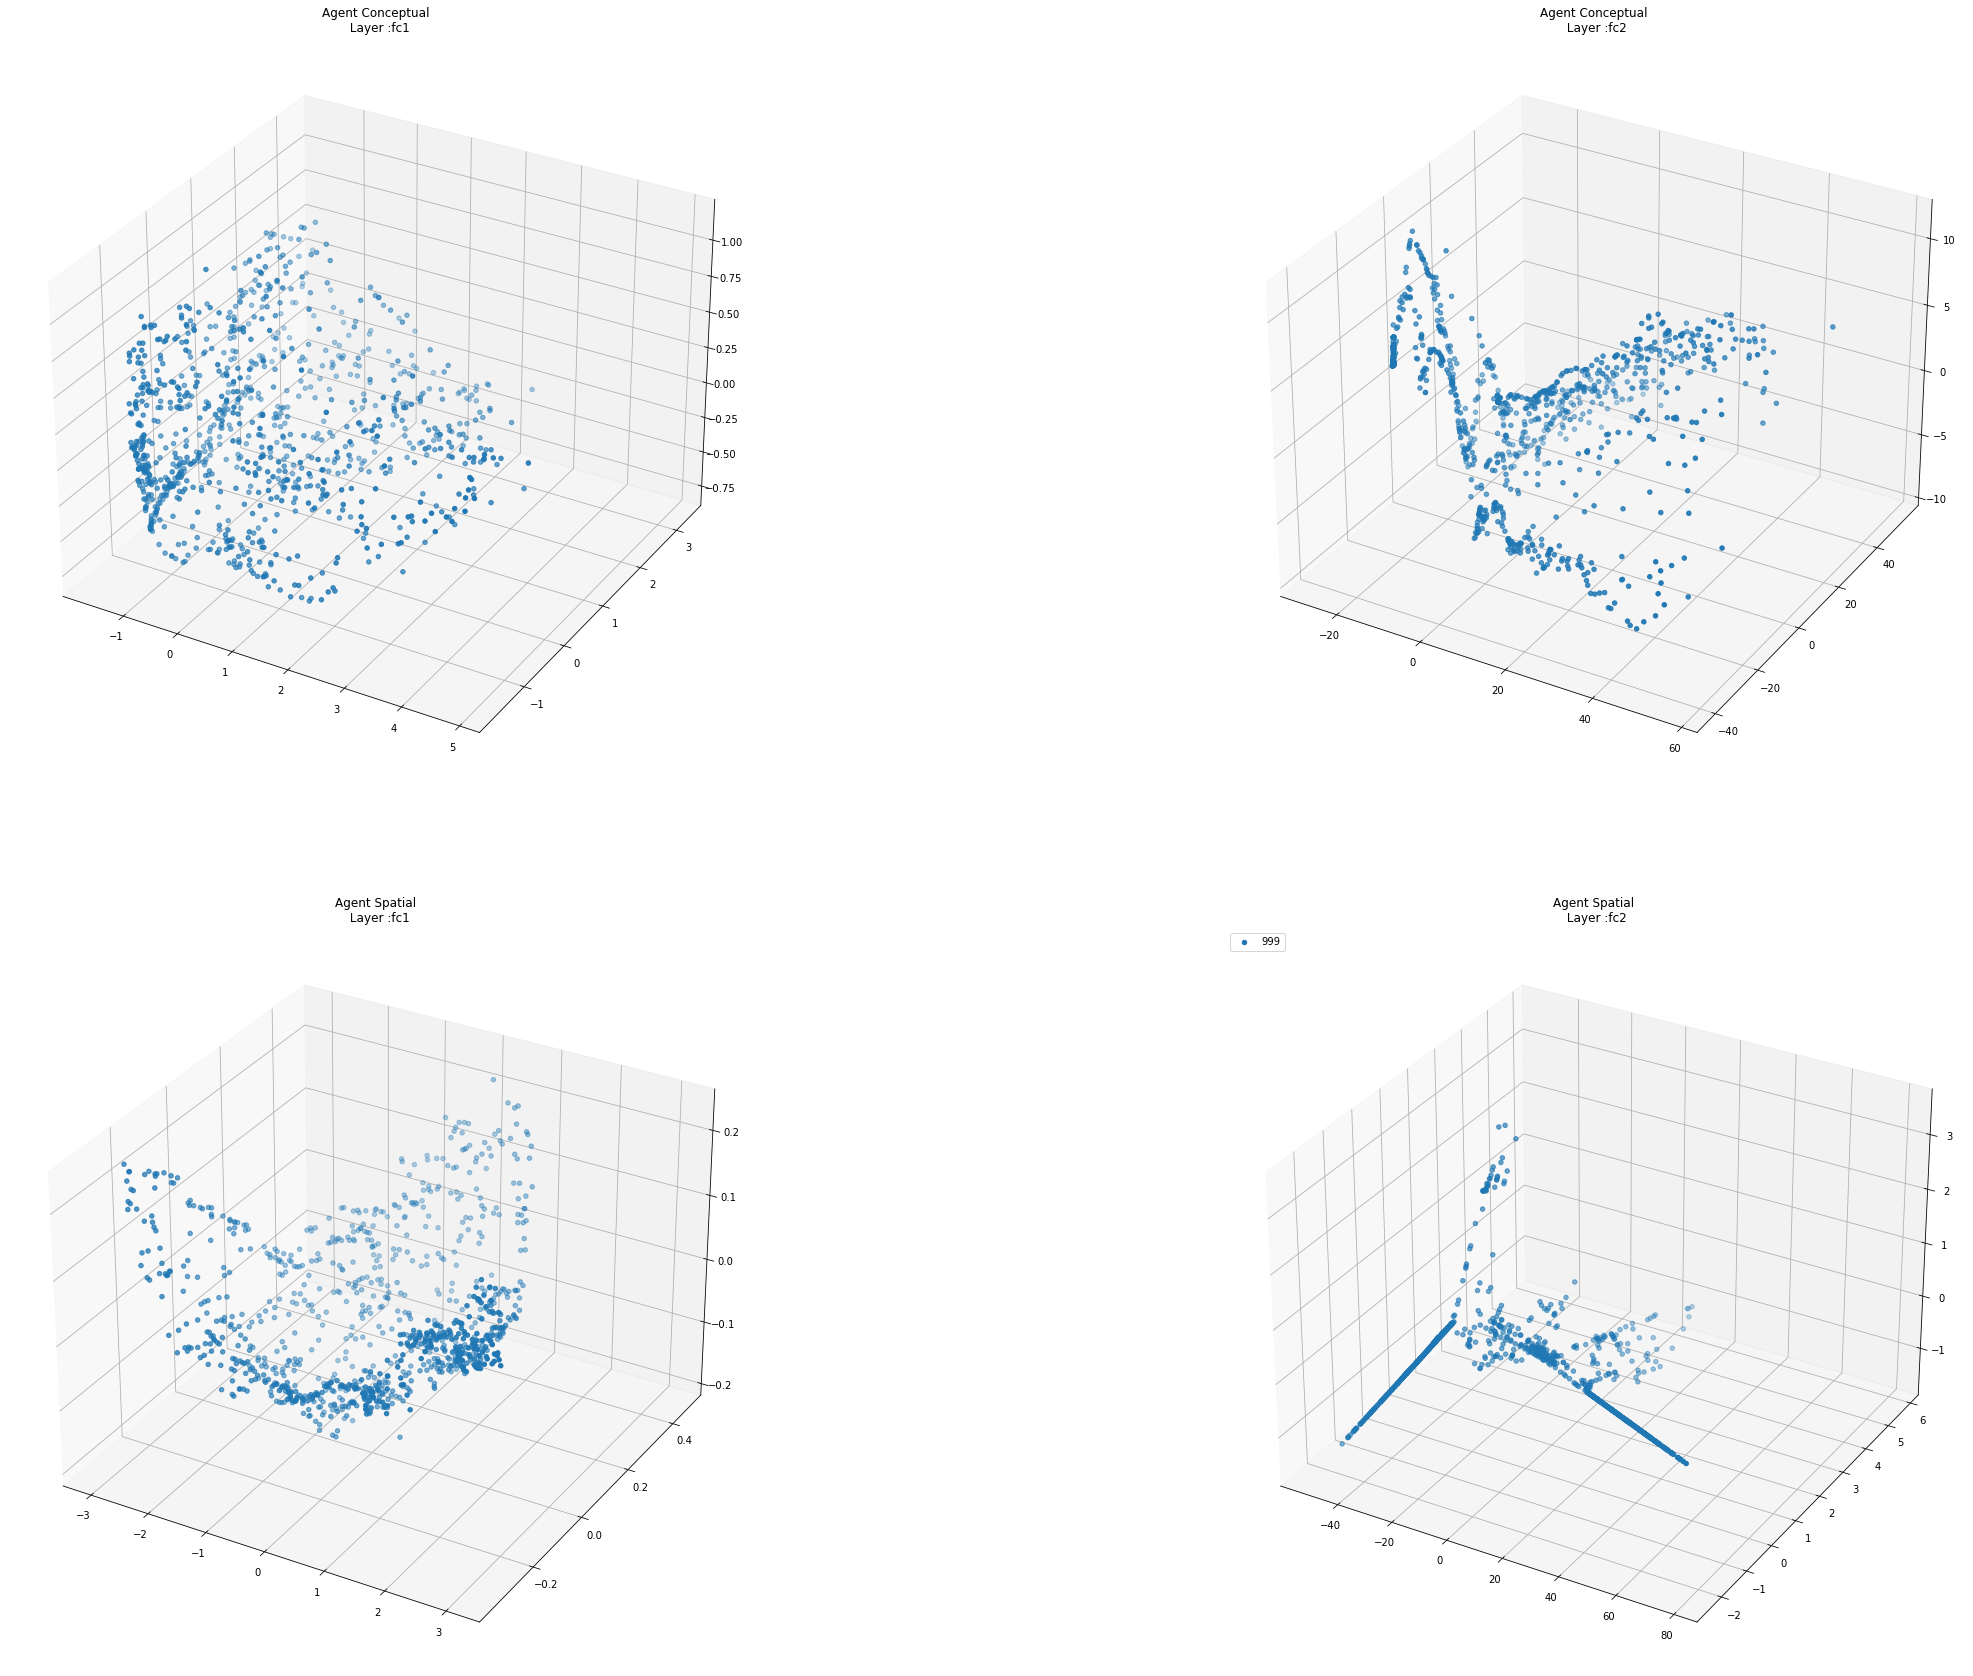

In [33]:
Name_agent_number = ["Conceptual","Spatial"]
embedding = Isomap(n_neighbors=15,n_components=3)
i = 1
fig = plt.figure(figsize=(40, 30))

for agent_number in range(len(Liste_models)):
    for layer in range(len(Names_hook)-1):
        ax = fig.add_subplot(len(Liste_models), len(Names_hook)-1,i,projection='3d')
        ax.set_title("Agent %s \n Layer :%s" % (Name_agent_number[agent_number], Names_hook[layer]))
        
        X = embedding.fit_transform(activity_layer[agent_number][layer])
        ax.scatter3D(X[:, 0], X[:, 1], X[:, 2],label = episode)
        
        i+=1
plt.legend(loc='upper left')
plt.show()



In [43]:
print(model_space.fc2[0].weight == model_weather.fc2[0].weight)
print(model_space.fc3[0].weight == model_weather.fc3[0].weight)



tensor([[True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True]])
tensor([[True, True, True, True, True, True, True, True, True, True]])


In [ ]:
weather_losses_g = []
spatial_losses_g = []

for i in range(ITERATION):
    weather_losses = []
    spatial_losses = []
    
    print("Iteration",i)
    losses = []
    val_losses = []

    for epoch in range(Epoch):

        loss = 0
        val_loss = 0 

        for x_batch, y_batch in train_loader:
            if spatial_task:
                x_batch = x_batch[:,0:2]
            else:
                x_batch = x_batch[:,2:5]

            optimizer.zero_grad()
            output = model(x_batch).squeeze(1)

            output_loss = criterion(output,y_batch)
            output_loss.backward()
            optimizer.step()

            loss += output_loss.detach().numpy()
        losses.append(loss/len(train_loader))

        with torch.no_grad():
            for x_val, y_val in val_loader:
                model.eval() 
                if spatial_task:
                    x_val = x_val[:,0:2]
                else:
                    x_val = x_val[:,2:5]
                yhat = model(x_val).squeeze(1)
                val_loss += criterion(yhat,y_val)
            val_losses.append(val_loss.item()/len(val_loader))


        if np.mod(epoch,10)==0: 
            clear_output()
            print("Epoch {}, val_loss {}".format(epoch, val_loss.item()/len(val_loader))) 
            fig = plt.figure()
            ax = fig.add_subplot(111)
            plt.plot(np.arange(len(val_losses)), val_losses)
            plt.ylabel('Loss')
            plt.xlabel('Epoch #')
            plt.show()
        
        
        training = Training_frozen_weights()
        spatial_task = False
        model_weather,val_losses = training.training_individual(model_weather,optimizer_weather,criterion,1,train_loader_weather,val_loader_weather,test_loader_weather,spatial_task,option_interleaved,do_analysis,type_an,network_type,frequence)
        weather_losses.append(val_losses)

        spatial_task = True
        model_space.fc2[0].weight = model_weather.fc2[0].weight
        model_space.fc3[0].weight = model_weather.fc3[0].weight

        for param in model_space.fc2.parameters():
            param.requires_grad = False

        for param in model_space.fc3.parameters():
            param.requires_grad = False

        model_space,val_losses = training.training_individual(model_space,optimizer_space,criterion,1,train_loader_space,val_loader_space,test_loader_space,spatial_task,option_interleaved,do_analysis,type_an,network_type,frequence)
        spatial_losses.append(val_losses)
        
    weather_losses_tensor = torch.tensor(weather_losses).flatten()
    spatial_losses_tensor = torch.tensor(spatial_losses).flatten()

    weather_losses_g.append(weather_losses_tensor.tolist())
    spatial_losses_g.append(spatial_losses_tensor.tolist())
       


